FGAN 2

Epoch 1/50 - Training Client 1/10
Client 1: D Loss = 0.6597, G Loss = 0.1481
Epoch 2/50 - Training Client 1/10
Client 1: D Loss = 0.7822, G Loss = 0.1012
Epoch 3/50 - Training Client 1/10
Client 1: D Loss = 0.9101, G Loss = 0.0789
Epoch 4/50 - Training Client 1/10
Client 1: D Loss = 1.0015, G Loss = 0.0644
Epoch 5/50 - Training Client 1/10
Client 1: D Loss = 1.0718, G Loss = 0.0554
Epoch 6/50 - Training Client 1/10
Client 1: D Loss = 1.1298, G Loss = 0.0486
Epoch 7/50 - Training Client 1/10
Client 1: D Loss = 1.1709, G Loss = 0.0434
Epoch 8/50 - Training Client 1/10
Client 1: D Loss = 1.1977, G Loss = 0.0394
Epoch 9/50 - Training Client 1/10
Client 1: D Loss = 1.2254, G Loss = 0.0362
Epoch 10/50 - Training Client 1/10
Client 1: D Loss = 1.2541, G Loss = 0.0336
Epoch 11/50 - Training Client 1/10
Client 1: D Loss = 1.2799, G Loss = 0.0313
Epoch 12/50 - Training Client 1/10
Client 1: D Loss = 1.2992, G Loss = 0.0293
Epoch 13/50 - Training Client 1/10
Client 1: D Loss = 1.3203, G Loss = 0.

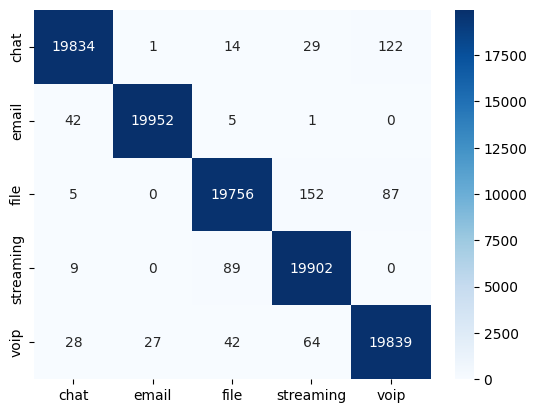

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LeakyReLU, BatchNormalization,
    Conv1D, MaxPooling1D, Flatten, Dropout
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import pandas as pd

# ==========================
# 🔹 Load and Preprocess Dataset
# ==========================
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']

# Load dataset
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# Extract features and labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude index column
Y_ISCX = df_ISCX["label"].values     # Extract target labels

# Normalize features
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_ISCX = tf.keras.utils.to_categorical(Y_ISCX, num_classes)

# ==========================
# 🔹 Define FGAN-II Components
# ==========================
LATENT_DIM = 100
NUM_CLIENTS = 10
BATCH_SIZE = 128
EPOCHS = 50
GENERATOR_UPDATES = 3

# === Generator Model ===
def build_generator():
    input_g = Input(shape=(LATENT_DIM,))
    x = Dense(256, kernel_initializer="he_normal")(input_g)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(512, kernel_initializer="he_normal")(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)
    return Model(input_g, x, name="FGAN2_Generator")

# === Discriminator Model ===
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(512, kernel_initializer="he_normal")(input_d)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(256, kernel_initializer="he_normal")(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    return Model(input_d, x, name="FGAN2_Discriminator")

# ==========================
# 🔹 Federated Learning Setup
# ==========================
client_models = [{"G": build_generator(), "D": build_discriminator()} for _ in range(NUM_CLIENTS)]

# Compile discriminators
for client in client_models:
    client["D"].compile(loss="binary_crossentropy", optimizer=Adam(0.0001, 0.5), metrics=["accuracy"])

# Split dataset among federated clients
client_data = np.array_split(X_ISCX, NUM_CLIENTS)
client_labels = np.array_split(y_ISCX, NUM_CLIENTS)

# ==========================
# 🔹 Federated Training of FGAN-II
# ==========================
def train_fgan2(client_id):
    generator = client_models[client_id]["G"]
    discriminator = client_models[client_id]["D"]

    # Define GAN model
    gan_input = Input(shape=(LATENT_DIM,))
    generated_samples = generator(gan_input)
    gan_output = discriminator(generated_samples)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="mean_squared_error", optimizer=Adam(0.0001, 0.5))

    half_batch = BATCH_SIZE // 2
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS} - Training Client {client_id+1}/{NUM_CLIENTS}")

        # Train Discriminator
        idx = np.random.randint(0, client_data[client_id].shape[0], half_batch)
        real_samples = client_data[client_id][idx] + 0.1 * np.random.normal(size=client_data[client_id][idx].shape)
        real_labels = np.ones((half_batch, 1)) * 0.95

        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        generated_samples = generator(noise, training=True)
        fake_labels = np.zeros((half_batch, 1)) + 0.05

        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        for _ in range(GENERATOR_UPDATES):
            noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
            g_loss = gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

        print(f"Client {client_id+1}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

for client_id in range(NUM_CLIENTS):
    train_fgan2(client_id)

# ==========================
# 🔹 Apply GMM for Pseudo-Labeling
# ==========================
discriminator_features = np.array([client_models[0]["D"].predict(client_data[i]) for i in range(NUM_CLIENTS)]).reshape(-1, 1)

gmm = GaussianMixture(n_components=num_classes, covariance_type='full')
pseudo_labels = gmm.fit_predict(discriminator_features)

# Convert pseudo-labels to one-hot encoding
pseudo_labels_onehot = tf.keras.utils.to_categorical(pseudo_labels, num_classes)

# Combine real and pseudo-labels
y_combined = np.concatenate([y_ISCX, pseudo_labels_onehot], axis=0)

# ==========================
# 🔹 Improved CNN Classifier
# ==========================
input_shape = (X_ISCX.shape[1], 1)
X_ISCX_reshaped = np.expand_dims(X_ISCX, axis=-1)

classifier = Sequential([
    Input(shape=input_shape),
    Conv1D(64, 3, activation=LeakyReLU(negative_slope=0.1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation=LeakyReLU(negative_slope=0.1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(256, 3, activation=LeakyReLU(negative_slope=0.1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation=LeakyReLU(negative_slope=0.1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

classifier.compile(optimizer=Adam(0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

classifier.fit(X_ISCX_reshaped, y_combined, epochs=50, batch_size=128, validation_split=0.1, callbacks=[early_stopping, reduce_lr])


# ==========================
# 🔹 Classification Report & Confusion Matrix
# ==========================
y_pred = classifier.predict(X_ISCX_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_ISCX, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS_ISCX))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.show()


Epoch 1/50 - Training Client 1/10
Client 1: D Loss = 0.8862, G Loss = 0.1241
Epoch 2/50 - Training Client 1/10
Client 1: D Loss = 0.9430, G Loss = 0.0841
Epoch 3/50 - Training Client 1/10
Client 1: D Loss = 1.0533, G Loss = 0.0636
Epoch 4/50 - Training Client 1/10
Client 1: D Loss = 1.1632, G Loss = 0.0518
Epoch 5/50 - Training Client 1/10
Client 1: D Loss = 1.2448, G Loss = 0.0440
Epoch 6/50 - Training Client 1/10
Client 1: D Loss = 1.3020, G Loss = 0.0384
Epoch 7/50 - Training Client 1/10
Client 1: D Loss = 1.3394, G Loss = 0.0345
Epoch 8/50 - Training Client 1/10
Client 1: D Loss = 1.3723, G Loss = 0.0312
Epoch 9/50 - Training Client 1/10
Client 1: D Loss = 1.4057, G Loss = 0.0288
Epoch 10/50 - Training Client 1/10
Client 1: D Loss = 1.4306, G Loss = 0.0267
Epoch 11/50 - Training Client 1/10
Client 1: D Loss = 1.4482, G Loss = 0.0249
Epoch 12/50 - Training Client 1/10
Client 1: D Loss = 1.4691, G Loss = 0.0233
Epoch 13/50 - Training Client 1/10
Client 1: D Loss = 1.4863, G Loss = 0.

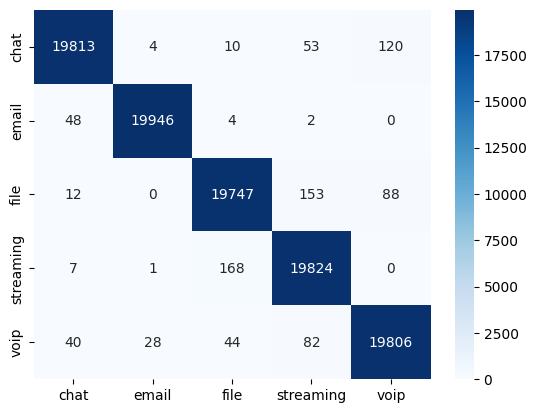

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LeakyReLU, BatchNormalization,
    Conv1D, MaxPooling1D, Flatten, Dropout
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import pandas as pd
import joblib
import os

# ==========================
# 🔹 Load and Preprocess Dataset
# ==========================
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']

# Load dataset
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# Extract features and labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude index column
Y_ISCX = df_ISCX["label"].values     # Extract target labels

# Normalize features
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_ISCX = tf.keras.utils.to_categorical(Y_ISCX, num_classes)

# Ensure models directory exists
os.makedirs("models", exist_ok=True)

# ==========================
# 🔹 Define FGAN-II Components
# ==========================
LATENT_DIM = 100
NUM_CLIENTS = 10
BATCH_SIZE = 128
EPOCHS = 50
GENERATOR_UPDATES = 3

# === Generator Model ===
def build_generator():
    input_g = Input(shape=(LATENT_DIM,))
    x = Dense(256, kernel_initializer="he_normal")(input_g)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(512, kernel_initializer="he_normal")(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)
    return Model(input_g, x, name="FGAN2_Generator")

# === Discriminator Model ===
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(512, kernel_initializer="he_normal")(input_d)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(256, kernel_initializer="he_normal")(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    return Model(input_d, x, name="FGAN2_Discriminator")

# ==========================
# 🔹 Federated Learning Setup
# ==========================
client_models = [{"G": build_generator(), "D": build_discriminator()} for _ in range(NUM_CLIENTS)]

# Compile discriminators
for client in client_models:
    client["D"].compile(loss="binary_crossentropy", optimizer=Adam(0.0001, 0.5), metrics=["accuracy"])

# Split dataset among federated clients
client_data = np.array_split(X_ISCX, NUM_CLIENTS)
client_labels = np.array_split(y_ISCX, NUM_CLIENTS)

# ==========================
# 🔹 Federated Training of FGAN-II
# ==========================
def train_fgan2(client_id):
    generator = client_models[client_id]["G"]
    discriminator = client_models[client_id]["D"]

    # Define GAN model
    gan_input = Input(shape=(LATENT_DIM,))
    generated_samples = generator(gan_input)
    gan_output = discriminator(generated_samples)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="mean_squared_error", optimizer=Adam(0.0001, 0.5))

    half_batch = BATCH_SIZE // 2
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS} - Training Client {client_id+1}/{NUM_CLIENTS}")

        # Train Discriminator
        idx = np.random.randint(0, client_data[client_id].shape[0], half_batch)
        real_samples = client_data[client_id][idx] + 0.1 * np.random.normal(size=client_data[client_id][idx].shape)
        real_labels = np.ones((half_batch, 1)) * 0.95

        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        generated_samples = generator(noise, training=True)
        fake_labels = np.zeros((half_batch, 1)) + 0.05

        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        for _ in range(GENERATOR_UPDATES):
            noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
            g_loss = gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

        print(f"Client {client_id+1}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

# Train all federated clients
for client_id in range(NUM_CLIENTS):
    train_fgan2(client_id)

# Save Global Generator & Discriminator
client_models[0]["G"].save("models/fgan2_generator.keras")
client_models[0]["D"].save("models/fgan2_discriminator.keras")
print("✅ Saved FGAN-II Generator & Discriminator in .keras format.")

# ==========================
# 🔹 Apply GMM for Pseudo-Labeling
# ==========================
discriminator_features = np.array([client_models[0]["D"].predict(client_data[i]) for i in range(NUM_CLIENTS)]).reshape(-1, 1)

gmm = GaussianMixture(n_components=num_classes, covariance_type='full')
pseudo_labels = gmm.fit_predict(discriminator_features)

# Save GMM Model
joblib.dump(gmm, "models/gmm_model.pkl")
print("✅ Saved GMM model as gmm_model.pkl.")

# Convert pseudo-labels to one-hot encoding
pseudo_labels_onehot = tf.keras.utils.to_categorical(pseudo_labels, num_classes)

# Combine real and pseudo-labels
y_combined = np.concatenate([y_ISCX, pseudo_labels_onehot], axis=0)

# ==========================
# 🔹 Improved CNN Classifier
# ==========================
input_shape = (X_ISCX.shape[1], 1)
X_ISCX_reshaped = np.expand_dims(X_ISCX, axis=-1)

classifier = Sequential([
    Input(shape=input_shape),
    Conv1D(64, 3, activation=LeakyReLU(negative_slope=0.1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation=LeakyReLU(negative_slope=0.1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(256, 3, activation=LeakyReLU(negative_slope=0.1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation=LeakyReLU(negative_slope=0.1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

classifier.compile(optimizer=Adam(0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


classifier.fit(X_ISCX_reshaped, y_combined, epochs=50, batch_size=128, validation_split=0.1)

# Save CNN Classifier
classifier.save("models/cnn_classifier.keras")
print("✅ Saved CNN classifier in .keras format.")



# ==========================
# 🔹 Classification Report & Confusion Matrix
# ==========================
y_pred = classifier.predict(X_ISCX_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_ISCX, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS_ISCX))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.show()

testing

In [ ]:
import numpy as np
import tensorflow as tf
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU

# Load the saved models
generator = tf.keras.models.load_model("models/fgan2_generator.keras")
discriminator = tf.keras.models.load_model("models/fgan2_discriminator.keras")
cnn_classifier = tf.keras.models.load_model(
    "models/cnn_classifier.keras",
    custom_objects={"LeakyReLU": LeakyReLU}
)
gmm_model = joblib.load("models/gmm_model.pkl")

print("✅ All models loaded successfully!")


✅ All models loaded successfully!


🔄 Loading pretrained models...
✅ Pretrained models loaded successfully.
🔍 Unique Labels in New Dataset Before Mapping: [0 1 2 3 4 5 6 7 8 9]
✅ Loaded new dataset with 180000 samples and 66 features.


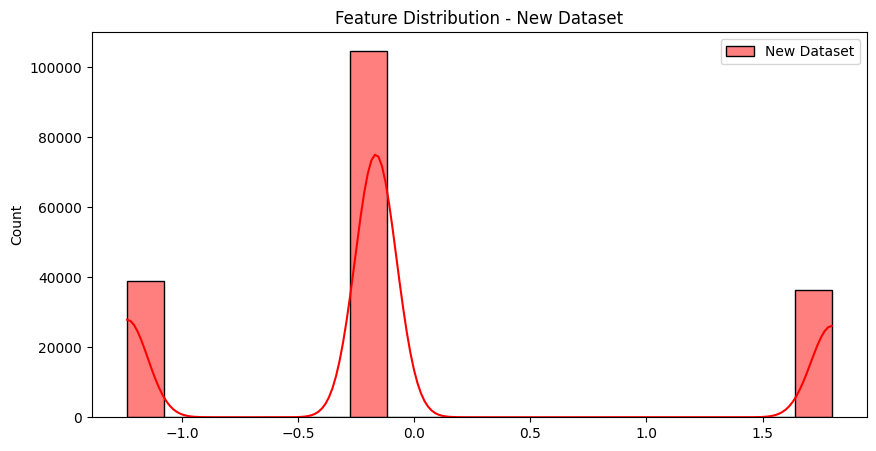

5625/5625 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
✅ Generated 180000 synthetic samples using the pretrained Generator.
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Discriminator Confidence (Real Samples): 0.7300
Discriminator Confidence (Fake Samples): 0.9762
🔄 Training new GMM for 10-class dataset...
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
✅ Saved new GMM model for 10 classes.
✅ Applied GMM for pseudo-labeling.

🔹 Evaluating CNN Classifier BEFORE Applying GMM...
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step

🔹 Classification Report BEFORE GMM:
              precision    recall  f1-score   support

      class1       0.06      0.13      0.08     18000
      class2       0.64      0.36      0.46     18000
      class3       0.00      0.00      0.00     18000
      class4       0.27      0.90      0.41     18000
      class5       0.14      0.04      0.07     18000
      class6       0.00      0.00      0.00     18000
      class7       0.00      0.00  

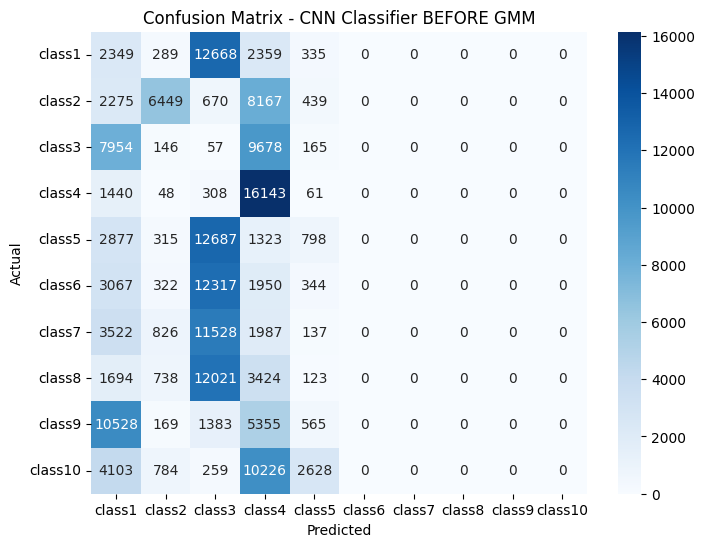


🔹 Evaluating CNN Classifier AFTER Applying GMM...
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step

🔹 Classification Report AFTER GMM:
              precision    recall  f1-score   support

      class1       0.04      0.11      0.06     26477
      class2       0.41      0.28      0.33     30339
      class3       0.09      0.31      0.14     35526
      class4       0.19      0.41      0.26     56483
      class5       0.12      0.05      0.08     25484
      class6       0.00      0.00      0.00     46124
      class7       0.00      0.00      0.00     35152
      class8       0.00      0.00      0.00     44452
      class9       0.00      0.00      0.00     20255
     class10       0.00      0.00      0.00     39708

    accuracy                           0.13    360000
   macro avg       0.09      0.12      0.09    360000
weighted avg       0.09      0.13      0.09    360000



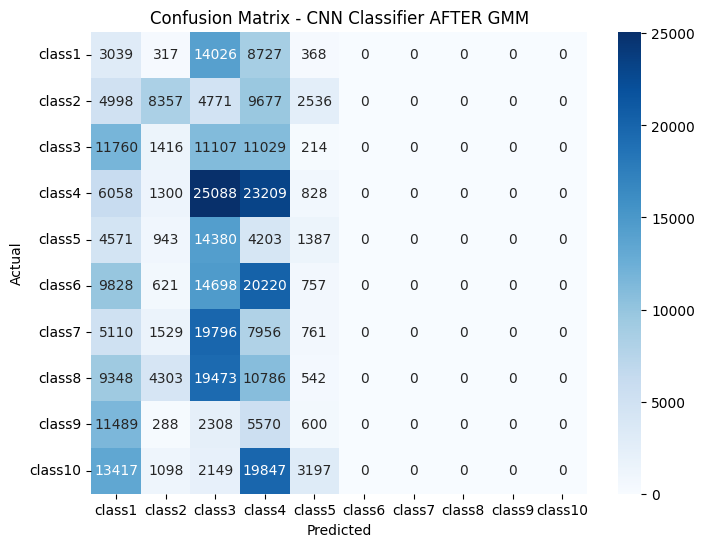

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import pandas as pd
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import LeakyReLU
# ==========================
# 🔹 Load Pretrained Models
# ==========================
print("🔄 Loading pretrained models...")

# Load Generator & Discriminator
generator = load_model("models/fgan2_generator.keras")
discriminator = load_model("models/fgan2_discriminator.keras")


# Load CNN Classifier
classifier = tf.keras.models.load_model(
    "models/cnn_classifier.keras",
    custom_objects={"LeakyReLU": LeakyReLU}
)

print("✅ Pretrained models loaded successfully.")

# ==========================
# 🔹 Load & Preprocess New 10-Class Dataset
# ==========================
LABELS_NEW = ['class1', 'class2', 'class3', 'class4', 'class5',
              'class6', 'class7', 'class8', 'class9', 'class10']

df_new = pd.read_csv("/content/pcapdroid_10class_each_normalized_cuttedfloefeature.csv")

# Extract features and labels
X_new = df_new.iloc[:, 1:].values  # Exclude index column
Y_new = df_new["label"].values  # Extract target labels

# 🔹 Verify unique labels
print("🔍 Unique Labels in New Dataset Before Mapping:", np.unique(Y_new))

# 🔹 Remap labels to ensure correct encoding
label_mapping = {original_label: new_index for new_index, original_label in enumerate(sorted(set(Y_new)))}
Y_new = np.array([label_mapping[label] for label in Y_new])

# 🔹 Convert to one-hot encoding
num_classes = len(set(Y_new))
y_new = tf.keras.utils.to_categorical(Y_new, num_classes)

# Normalize features using the SAME scaler from training
scaler = StandardScaler()
X_new = scaler.fit_transform(X_new)

# Reshape for CNN
X_new_reshaped = np.expand_dims(X_new, axis=-1)

print(f"✅ Loaded new dataset with {X_new.shape[0]} samples and {X_new.shape[1]} features.")

# ==========================
# 🔹 Check Feature Distribution Shift
# ==========================
plt.figure(figsize=(10, 5))
sns.histplot(X_new[:, 0], color="red", label="New Dataset", kde=True)
plt.legend()
plt.title("Feature Distribution - New Dataset")
plt.show()

# ==========================
# 🔹 Generate Synthetic Data
# ==========================
LATENT_DIM = 100
num_samples = X_new.shape[0]

noise = np.random.normal(0, 1, (num_samples, LATENT_DIM))
generated_samples = generator.predict(noise)

print(f"✅ Generated {num_samples} synthetic samples using the pretrained Generator.")

# ==========================
# 🔹 Discriminator Evaluation
# ==========================
real_scores = discriminator.predict(X_new)
fake_scores = discriminator.predict(generated_samples)

print(f"Discriminator Confidence (Real Samples): {np.mean(real_scores):.4f}")
print(f"Discriminator Confidence (Fake Samples): {np.mean(fake_scores):.4f}")

# ==========================
# 🔹 Train a New GMM for 10 Classes
# ==========================
print("🔄 Training new GMM for 10-class dataset...")
discriminator_features = discriminator.predict(X_new).reshape(-1, 1)
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
gmm.fit(discriminator_features)

# Save the newly trained GMM model
joblib.dump(gmm, "models/gmm_10class.pkl")
print("✅ Saved new GMM model for 10 classes.")

# Apply GMM for Pseudo-Labeling
pseudo_labels = gmm.predict(discriminator_features)
pseudo_labels_onehot = tf.keras.utils.to_categorical(pseudo_labels, num_classes)

print("✅ Applied GMM for pseudo-labeling.")

# ==========================
# 🔹 Evaluate CNN Classifier on New Dataset (Before & After GMM)
# ==========================
print("\n🔹 Evaluating CNN Classifier BEFORE Applying GMM...")

y_pred_raw = classifier.predict(X_new_reshaped)
y_pred_classes_raw = np.argmax(y_pred_raw, axis=1)
y_true_classes = np.argmax(y_new, axis=1)

print("\n🔹 Classification Report BEFORE GMM:")
print(classification_report(y_true_classes, y_pred_classes_raw, target_names=LABELS_NEW))

# Confusion Matrix Before GMM
conf_matrix_raw = confusion_matrix(y_true_classes, y_pred_classes_raw)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_raw, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_NEW, yticklabels=LABELS_NEW)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN Classifier BEFORE GMM")
plt.show()

# ==========================
# 🔹 Evaluate CNN Classifier on Combined Labels (After GMM)
# ==========================
y_combined = np.concatenate([y_new, pseudo_labels_onehot], axis=0)
X_combined_reshaped = np.concatenate([X_new_reshaped, X_new_reshaped], axis=0)

print("\n🔹 Evaluating CNN Classifier AFTER Applying GMM...")

y_pred_combined = classifier.predict(X_combined_reshaped)
y_pred_classes_combined = np.argmax(y_pred_combined, axis=1)
y_true_classes_combined = np.argmax(y_combined, axis=1)

print("\n🔹 Classification Report AFTER GMM:")
print(classification_report(y_true_classes_combined, y_pred_classes_combined, target_names=LABELS_NEW))

# Confusion Matrix After GMM
conf_matrix_combined = confusion_matrix(y_true_classes_combined, y_pred_classes_combined)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_combined, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_NEW, yticklabels=LABELS_NEW)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN Classifier AFTER GMM")
plt.show()
